In [8]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

ModuleNotFoundError: No module named 'pywt'

In [6]:
# CARREGAR OS DADOS

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(0) 

    ecg_normal_sample = random.sample(ecg_normal_id, unlabel) if len(ecg_normal_id) >= unlabel else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X , ids_ecgs

In [12]:
import pandas as pd
import numpy as np
import h5py
import random

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, filtrado):
    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                        "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                        "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                        "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                        "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    # Seleciona os índices dos exames para cada classe (usando as colunas indicadas)
    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False)]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                  (dados.iloc[:, 4] == False) &
                                  (dados.iloc[:, 5] == True) &
                                  (dados.iloc[:, 6] == False) &
                                  (dados.iloc[:, 7] == False) &
                                  (dados.iloc[:, 8] == False) &
                                  (dados.iloc[:, 9] == False) &
                                  (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                  (dados.iloc[:, 4] == False) &
                                  (dados.iloc[:, 5] == False) &
                                  (dados.iloc[:, 6] == True) &
                                  (dados.iloc[:, 7] == False) &
                                  (dados.iloc[:, 8] == False) &
                                  (dados.iloc[:, 9] == False) &
                                  (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                (dados.iloc[:, 4] == False) &
                                (dados.iloc[:, 5] == False) &
                                (dados.iloc[:, 6] == False) &
                                (dados.iloc[:, 7] == True) &
                                (dados.iloc[:, 8] == False) &
                                (dados.iloc[:, 9] == False) &
                                (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                (dados.iloc[:, 4] == False) &
                                (dados.iloc[:, 5] == False) &
                                (dados.iloc[:, 6] == False) &
                                (dados.iloc[:, 7] == False) &
                                (dados.iloc[:, 8] == True) &
                                (dados.iloc[:, 9] == False) &
                                (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                (dados.iloc[:, 4] == False) &
                                (dados.iloc[:, 5] == False) &
                                (dados.iloc[:, 6] == False) &
                                (dados.iloc[:, 7] == False) &
                                (dados.iloc[:, 8] == False) &
                                (dados.iloc[:, 9] == True) &
                                (dados.iloc[:, 13] == False)]

    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    # Remove os exames que estão na lista de interferências
    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                      (dados.iloc[:, 14].isin(arquivos_usados)) &
                                      (dados.iloc[:, 4] == False) &
                                      (dados.iloc[:, 5] == False) &
                                      (dados.iloc[:, 6] == False) &
                                      (dados.iloc[:, 7] == False) &
                                      (dados.iloc[:, 8] == False) &
                                      (dados.iloc[:, 9] == False)]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                      (dados.iloc[:, 14].isin(arquivos_usados)) &
                                      (dados.iloc[:, 4] == True) &
                                      (dados.iloc[:, 5] == False) &
                                      (dados.iloc[:, 6] == False) &
                                      (dados.iloc[:, 7] == False) &
                                      (dados.iloc[:, 8] == False) &
                                      (dados.iloc[:, 9] == False) &
                                      (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                  (dados.iloc[:, 14].isin(arquivos_usados)) &
                                  (dados.iloc[:, 4] == False) &
                                  (dados.iloc[:, 5] == False) &
                                  (dados.iloc[:, 6] == False) &
                                  (dados.iloc[:, 7] == True) &
                                  (dados.iloc[:, 8] == False) &
                                  (dados.iloc[:, 9] == False) &
                                  (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                  (dados.iloc[:, 14].isin(arquivos_usados)) &
                                  (dados.iloc[:, 4] == False) &
                                  (dados.iloc[:, 5] == False) &
                                  (dados.iloc[:, 6] == False) &
                                  (dados.iloc[:, 7] == False) &
                                  (dados.iloc[:, 8] == True) &
                                  (dados.iloc[:, 9] == False) &
                                  (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                  (dados.iloc[:, 14].isin(arquivos_usados)) &
                                  (dados.iloc[:, 4] == False) &
                                  (dados.iloc[:, 5] == False) &
                                  (dados.iloc[:, 6] == False) &
                                  (dados.iloc[:, 7] == False) &
                                  (dados.iloc[:, 8] == False) &
                                  (dados.iloc[:, 9] == True) &
                                  (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    # Coleta os IDs de exame de cada classe
    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    # Seleciona os exames de forma sequencial (primeiros N)
    ecg_normal_sample = ecg_normal_id[:unlabel] if len(ecg_normal_id) >= unlabel else ecg_normal_id
    ecg_umdavb_sample = ecg_umdavb_id[:umdavb] if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = ecg_rbbb_id[:rbbb] if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = ecg_lbbb_id[:lbbb] if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = ecg_sb_id[:sb] if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = ecg_st_id[:st] if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = ecg_af_id[:af] if len(ecg_af_id) >= af else ecg_af_id

    # Concatena todos os IDs selecionados
    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    # Seleção dos arquivos HDF5 com base no parâmetro 'filtrado'
    if filtrado == True:
        arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                         "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    else:
        arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                         '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # IDs dos exames selecionados

    all_tracings = []
    for exam_id in exam_ids_to_cluster:
        found = False
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True
                    break
            except ValueError as e:
                pass
            except Exception as e:
                pass
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    X = np.array(all_tracings)
    return X, ids_ecgs


In [13]:
X, ids_ecgs = carregar_ecgs(unlabel=10,umdavb=0,rbbb=0,lbbb=0,sb=0,st=0,af=0,filtrado=True)


Número de linhas ecg_normal_linhas: 272407
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 252167
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 10
Número de ecgs que eram pra ser processados: 10
Número total de traçados processados: 10


In [19]:
print(ids_ecgs[1])

2873686


In [15]:
import torch
import numpy as np
import neurokit2 as nk
from ts2vg import NaturalVG
from torch_geometric.data import Data
from joblib import Parallel, delayed
from tqdm import tqdm

DEBUG = True  # Flag para mensagens de depuração

def debug_print(msg):
    if DEBUG:
        print("[DEBUG]", msg)

def compute_node_features(time_series, edges):
    """
    Calcula as features de cada nó:
      - amplitude: valor da amostra;
      - derivada: diferença com o nó anterior (primeiro nó = 0);
      - grau: número de arestas incidentes.
    """
    n = len(time_series)
    amplitude = time_series.reshape(-1, 1)
    derivative = np.concatenate(([0], np.diff(time_series))).reshape(-1, 1)
    
    if edges:
        edges_array = np.array(edges)
        # Separa os nós de origem e destino
        u, v = edges_array[:, 0], edges_array[:, 1]
        counts = np.bincount(np.concatenate([u, v]), minlength=n)
    else:
        counts = np.zeros(n)
    degree = counts.reshape(-1, 1)
    
    features = np.hstack([amplitude, derivative, degree])
    return features

def get_middle_r_peak(lead_series, sampling_rate=400):
    """
    Detecta os picos R na lead utilizando nk.ecg_findpeaks do NeuroKit e retorna o pico "do meio".
    """
    peaks_dict = nk.ecg_findpeaks(lead_series, sampling_rate=sampling_rate)
    peaks = np.array(peaks_dict["ECG_R_Peaks"])
    
    if peaks.size == 0:
        debug_print("Nenhum pico R encontrado; usando índice central")
        return len(lead_series) // 2
    
    if len(peaks) % 2 == 0:
        middle_index = peaks[len(peaks) // 2 - 1]
    else:
        middle_index = peaks[len(peaks) // 2]
    
    debug_print(f"Detectado pico R do meio em índice: {middle_index}")
    return middle_index

def process_lead(lead_series):
    """
    Processa uma única lead:
      - Seleciona 1000 pontos centrados no pico R.
      - Constrói o grafo de visibilidade utilizando NaturalVG.
      - Calcula as features dos nós.
    """
    r_peak = get_middle_r_peak(lead_series, sampling_rate=400)
    
    # Define a janela de 1000 pontos
    start_index = max(0, r_peak - 500)
    end_index = min(len(lead_series), r_peak + 500)
    lead_segment = lead_series[start_index:end_index]
    debug_print(f"Segmento extraído: start={start_index}, end={end_index}, shape={lead_segment.shape}")
    
    vg = NaturalVG()
    vg.build(lead_segment)
    edges = vg.edges  # lista de arestas (tuplas (i, j))
    debug_print(f"Número de arestas no grafo: {len(edges)}")
    
    node_features = compute_node_features(lead_segment, edges)
    
    # Converter os índices das arestas para tensor
    if edges:
        edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.int64)
    
    return Data(x=torch.tensor(node_features, dtype=torch.float32), edge_index=edge_index)

def process_exam(ecg, exam_id):
    """
    Processa um exame (ECG) com 12 leads e retorna:
      - exam_id
      - dicionário com cada lead processada.
    """
    debug_print(f"Processando exame: {exam_id}")
    exam_graphs = {
        f"lead_{lead_index}": process_lead(ecg[lead_index])
        for lead_index in range(12)
    }
    return exam_id, exam_graphs

if __name__ == '__main__':
    # SUPOSIÇÕES:
    # - X: lista/array de ECGs (cada ECG com shape (12, n_samples)).
    # - ids_ecgs: lista de exam_ids, na mesma ordem de X.
    exam_ids_list = ids_ecgs  # Certifique-se de que 'ids_ecgs' esteja definido

    print("Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...")
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_exam)(ecg, exam_ids_list[idx])
        for idx, ecg in enumerate(tqdm(X, desc="Processando exames"))
    )

    # Reconstruindo o dicionário com os grafos usando os resultados
    graphs_by_exam = {exam_id: graphs for exam_id, graphs in results}

    # Exibe alguns detalhes de depuração
    for exam_id in list(graphs_by_exam.keys())[:3]:
        debug_print(f"Exame {exam_id}:")
        for lead_key, data in graphs_by_exam[exam_id].items():
            debug_print(f"  {lead_key}: x shape = {data.x.shape}, edge_index shape = {data.edge_index.shape}")

    dados_salvos = {"grafos": graphs_by_exam}
    output_filename = "unlabel.pt"
    torch.save(dados_salvos, output_filename)
    print(f"Grafos salvos com sucesso em {output_filename}")


Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...


Processando exames: 100%|██████████| 10/10 [00:00<00:00, 59.27it/s]


[DEBUG] Processando exame: 1467619
[DEBUG] Detectado pico R do meio em índice: 1809
[DEBUG] Segmento extraído: start=1309, end=2309, shape=(1000,)
[DEBUG] Número de arestas no grafo: 23168
[DEBUG] Processando exame: 2873686
[DEBUG] Detectado pico R do meio em índice: 1890
[DEBUG] Segmento extraído: start=1390, end=2390, shape=(1000,)
[DEBUG] Número de arestas no grafo: 12693
[DEBUG] Detectado pico R do meio em índice: 1810
[DEBUG] Segmento extraído: start=1310, end=2310, shape=(1000,)
[DEBUG] Número de arestas no grafo: 30008
[DEBUG] Processando exame: 384368
[DEBUG] Detectado pico R do meio em índice: 1891
[DEBUG] [DEBUG]Detectado pico R do meio em índice: 2050 
Segmento extraído: start=1391, end=2391, shape=(1000,)
[DEBUG] Segmento extraído: start=1550, end=2550, shape=(1000,)
[DEBUG] Número de arestas no grafo: 13524
[DEBUG] Número de arestas no grafo: 21875
[DEBUG] Detectado pico R do meio em índice: 1878
[DEBUG] Segmento extraído: start=1378, end=2378, shape=(1000,)
[DEBUG] Número

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    8.4s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.5s remaining:    3.6s


[DEBUG] Detectado pico R do meio em índice: 1993
[DEBUG] Segmento extraído: start=1493, end=2493, shape=(1000,)
[DEBUG] Número de arestas no grafo: 17698
[DEBUG] Detectado pico R do meio em índice: 2395
[DEBUG] Segmento extraído: start=1895, end=2895, shape=(1000,)
[DEBUG] Número de arestas no grafo: 10305
[DEBUG] Detectado pico R do meio em índice: 2003
[DEBUG] Segmento extraído: start=1503, end=2503, shape=(1000,)
[DEBUG] Número de arestas no grafo: 8882
[DEBUG] Detectado pico R do meio em índice: 2401
[DEBUG] Segmento extraído: start=1901, end=2901, shape=(1000,)
[DEBUG] Número de arestas no grafo: 12354
[DEBUG] Detectado pico R do meio em índice: 1992
[DEBUG] Segmento extraído: start=1492, end=2492, shape=(1000,)
[DEBUG] Número de arestas no grafo: 15028
[DEBUG] Detectado pico R do meio em índice: 1979
[DEBUG] Segmento extraído: start=1479, end=2479, shape=(1000,)
[DEBUG] Número de arestas no grafo: 8268
[DEBUG] Detectado pico R do meio em índice: 1973
[DEBUG] Segmento extraído: st

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.7s finished


In [30]:
import torch

# Carregar grafo do primeiro método
data1 = torch.load("unlabel.pt", map_location='cpu', weights_only= False)
# Carregar grafo do segundo método
data2 = torch.load("exames_com_labels.pt", map_location='cpu', weights_only = False)

# Supondo que você tenha um exam_id específico, por exemplo:
exam_id = "2873686"  # vindo, por exemplo, de uma entrada do usuário
exam_id = int(exam_id)  # converte para inteiro

# Obter os grafos
if exam_id in data1["grafos"]:
    grafo1 = data1["grafos"][exam_id]
    print("Método 1:", grafo1)
else:
    print(f"Exam ID {exam_id} não encontrado em unlabel.pt")

if exam_id in data2["grafos"]:
    grafo2 = data2["grafos"][exam_id]
    print("Método 2:", grafo2)
else:
    print(f"Exam ID {exam_id} não encontrado em exames_com_labels.pt")


Método 1: {'lead_0': Data(x=[1000, 3], edge_index=[2, 12693]), 'lead_1': Data(x=[1000, 3], edge_index=[2, 13524]), 'lead_2': Data(x=[1000, 3], edge_index=[2, 5439]), 'lead_3': Data(x=[1000, 3], edge_index=[2, 8619]), 'lead_4': Data(x=[1000, 3], edge_index=[2, 8765]), 'lead_5': Data(x=[1000, 3], edge_index=[2, 8230]), 'lead_6': Data(x=[1000, 3], edge_index=[2, 15268]), 'lead_7': Data(x=[1000, 3], edge_index=[2, 17723]), 'lead_8': Data(x=[1000, 3], edge_index=[2, 19894]), 'lead_9': Data(x=[1000, 3], edge_index=[2, 18992]), 'lead_10': Data(x=[1000, 3], edge_index=[2, 15934]), 'lead_11': Data(x=[1000, 3], edge_index=[2, 15591])}
Método 2: {'grafo': Data(x=[1000, 48], edge_index=[2, 13524]), 'label': array([0, 0, 0, 0, 0, 0])}


In [25]:
import torch

data1 = torch.load("unlabel.pt", map_location='cpu', weights_only= False)
print("Chaves em unlabel.pt:")
for key in data1["grafos"].keys():
    print(key, type(key))

data2 = torch.load("exames_com_labels.pt", map_location='cpu',weights_only= False )
print("Chaves em exames_com_labels.pt:")
for key in data2["grafos"].keys():
    print(key, type(key))


Chaves em unlabel.pt:
1169160 <class 'int'>
2873686 <class 'int'>
271011 <class 'int'>
384368 <class 'int'>
2950575 <class 'int'>
1467619 <class 'int'>
1537328 <class 'int'>
981735 <class 'int'>
1237983 <class 'int'>
2854912 <class 'int'>
Chaves em exames_com_labels.pt:
1169160 <class 'int'>
2873686 <class 'int'>
271011 <class 'int'>
384368 <class 'int'>
2950575 <class 'int'>
1467619 <class 'int'>
1537328 <class 'int'>
981735 <class 'int'>
1237983 <class 'int'>
2854912 <class 'int'>


In [ ]:
# salvar_grafos_ecg_pyg_otimizado_dtype.py
import torch
import numpy as np
import neurokit2 as nk
from ts2vg import NaturalVG
from torch_geometric.data import Data
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_node_features(time_series, edges):
    """
    Calcula as features de cada nó:
      - amplitude: valor da amostra;
      - derivada: diferença com o nó anterior (primeiro nó = 0);
      - grau: número de arestas incidentes.
    
    Parâmetros:
      time_series: numpy array de forma (n,) com os valores da lead.
      edges: lista de tuplas (i, j) definindo as arestas do grafo.
      
    Retorna:
      features: numpy array de forma (n, 3) com [amplitude, derivada, grau] para cada nó.
    """
    n = len(time_series)
    amplitude = time_series.reshape(-1, 1)
    derivative = np.concatenate(([0], np.diff(time_series))).reshape(-1, 1)
    
    if edges:
        edges_array = np.array(edges)
        # Separa os nós de origem e destino
        u, v = edges_array[:, 0], edges_array[:, 1]
        counts = np.bincount(np.concatenate([u, v]), minlength=n)
    else:
        counts = np.zeros(n)
    degree = counts.reshape(-1, 1)
    
    features = np.hstack([amplitude, derivative, degree])
    return features

def get_middle_r_peak(lead_series, sampling_rate=400):
    """
    Detecta os picos R na lead utilizando nk.ecg_findpeaks do NeuroKit e retorna o pico "do meio".
    Caso nenhum pico seja encontrado, retorna o índice central da série.
    
    Parâmetros:
      lead_series: numpy array com a lead do ECG.
      sampling_rate: taxa de amostragem do sinal (em Hz).
      
    Retorna:
      índice do pico R selecionado.
    """
    peaks_dict = nk.ecg_findpeaks(lead_series, sampling_rate=sampling_rate)
    # Converte os picos para um array NumPy, para facilitar a verificação do tamanho
    peaks = np.array(peaks_dict["ECG_R_Peaks"])
    
    if peaks.size == 0:
        # Se nenhum pico for encontrado, retorna o índice central
        return len(lead_series) // 2
    
    # Se o número de picos for par, escolhe o pico da metade inferior (ex: 10 picos -> escolhe o 5º)
    if len(peaks) % 2 == 0:
        middle_index = peaks[len(peaks) // 2 - 1]
    else:
        middle_index = peaks[len(peaks) // 2]
    return middle_index

def process_lead(lead_series):
    """
    Processa uma única lead:
      - Detecta os picos R e seleciona o pico do meio utilizando o NeuroKit.
      - Seleciona 1000 pontos centrados no pico R (500 pontos antes e 500 pontos após).
      - Constrói o grafo de visibilidade utilizando NaturalVG.
      - Calcula as features dos nós (amplitude, derivada e grau).
      - Converte as arestas e features para tensores do PyTorch com tipos de dados otimizados.
      - Retorna um objeto Data do PyTorch Geometric.
    """
    # Detecta o pico R "do meio" da lead
    r_peak = get_middle_r_peak(lead_series, sampling_rate=400)
    
    # Define a janela de 1000 pontos (500 antes e 500 após o pico R)
    start_index = max(0, r_peak - 500)
    end_index = min(len(lead_series), r_peak + 500)
    lead_segment = lead_series[start_index:end_index]

    vg = NaturalVG()
    vg.build(lead_segment)
    edges = vg.edges  # lista de arestas (cada aresta é uma tupla (i, j))
    
    node_features = compute_node_features(lead_segment, edges)
    
    # Converter os índices das arestas para int64 (torch.long)
    if edges:
        edge_index = torch.tensor(edges, dtype=torch.int64).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.int64)
    
    # Converter as features para float32 para maior estabilidade
    node_features_tensor = torch.tensor(node_features, dtype=torch.float32)
    return Data(x=node_features_tensor, edge_index=edge_index)

def process_exam(ecg, exam_id):
    """
    Processa um exame (ECG) com 12 leads.
    Retorna:
      exam_id e um dicionário com as 12 leads processadas.
    """
    exam_graphs = {
        f"lead_{lead_index}": process_lead(ecg[lead_index])
        for lead_index in range(12)
    }
    return exam_id, exam_graphs

if __name__ == '__main__':
    # =============================================================================
    # SUPOSIÇÕES:
    # - As variáveis X e ids_ecgs já estão definidas:
    #     X: array ou lista de ECGs, onde cada ECG tem formato (12, n_samples).
    #     ids_ecgs: lista com os exam_ids correspondentes, na mesma ordem de X.
    # =============================================================================
    exam_ids_list = ids_ecgs  # certifique-se de que 'ids_ecgs' já esteja definido

    print("Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...")

    # Processa os exames em paralelo utilizando Joblib com uma barra de progresso (TQDM)
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_exam)(ecg, exam_ids_list[idx])
        for idx, ecg in enumerate(tqdm(X, desc="Processando exames"))
    )

    # Reconstrói o dicionário com os grafos usando os resultados obtidos
    graphs_by_exam = {exam_id: graphs for exam_id, graphs in results}

    dados_salvos = {"grafos": graphs_by_exam}

    output_filename = "unlabel.pt"
    torch.save(dados_salvos, output_filename)
    print(f"Grafos salvos com sucesso em {output_filename}")


Iniciando a criação dos grafos de visibilidade para cada ECG e cada lead...


Processando exames:   0%|          | 0/15000 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


Processando exames:   0%|          | 64/15000 [00:06<26:24,  9.42it/s][Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.7s
Processando exames:   1%|          | 96/15000 [00:06<17:27, 14.22it/s][Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
Processando exames:   1%|          | 160/15000 [00:07<08:40, 28.53it/s][Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    8.0s
Processando exames:   1%|▏         | 192/15000 [00:08<06:41, 36.90it/s][Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    8.5s
Processando exames:   2%|▏         | 256/15000 [00:08<04:33, 53.88it/s][Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done

Grafos salvos com sucesso em unlabel.pt


: 

Grafo do exam_id 2873686 - lead 1 criado com 1000 nós e 13524 arestas.


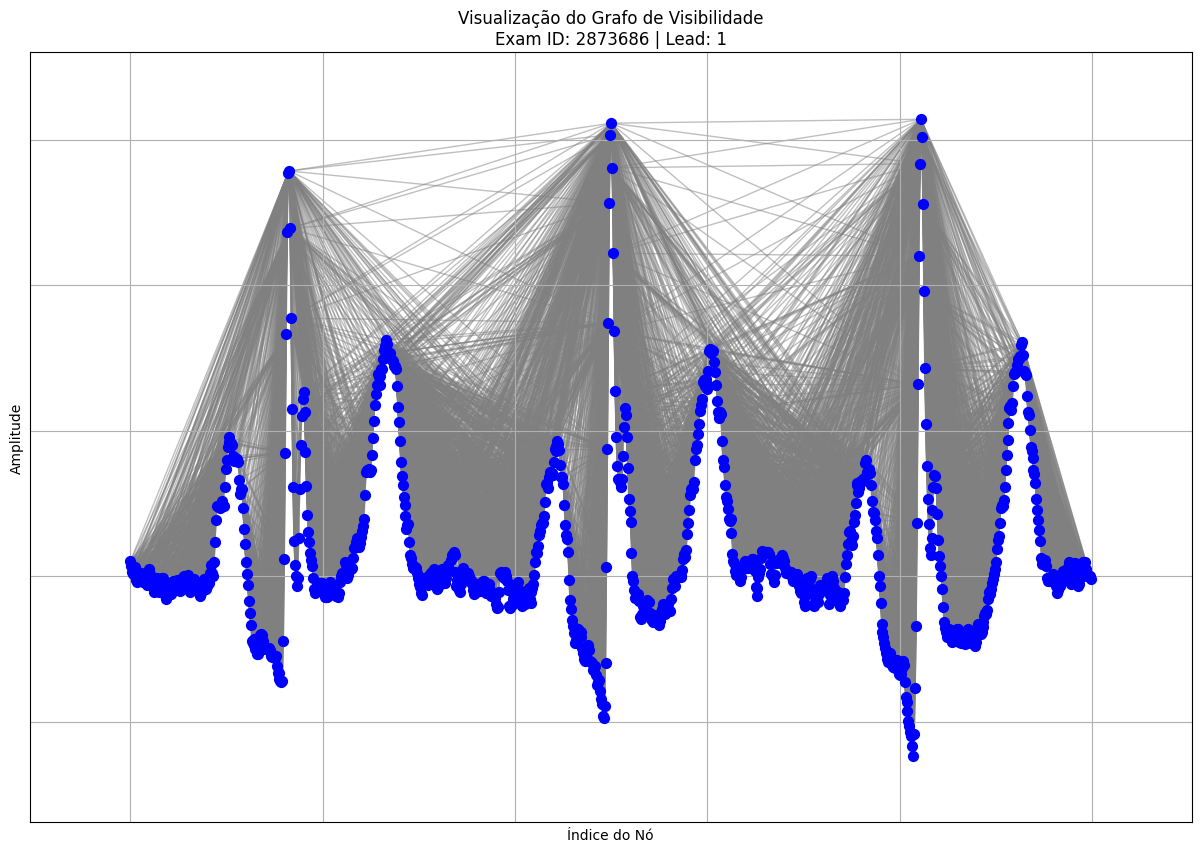

Grafo do exam_id 2873686 - lead 1 criado com 1000 nós e 13524 arestas.


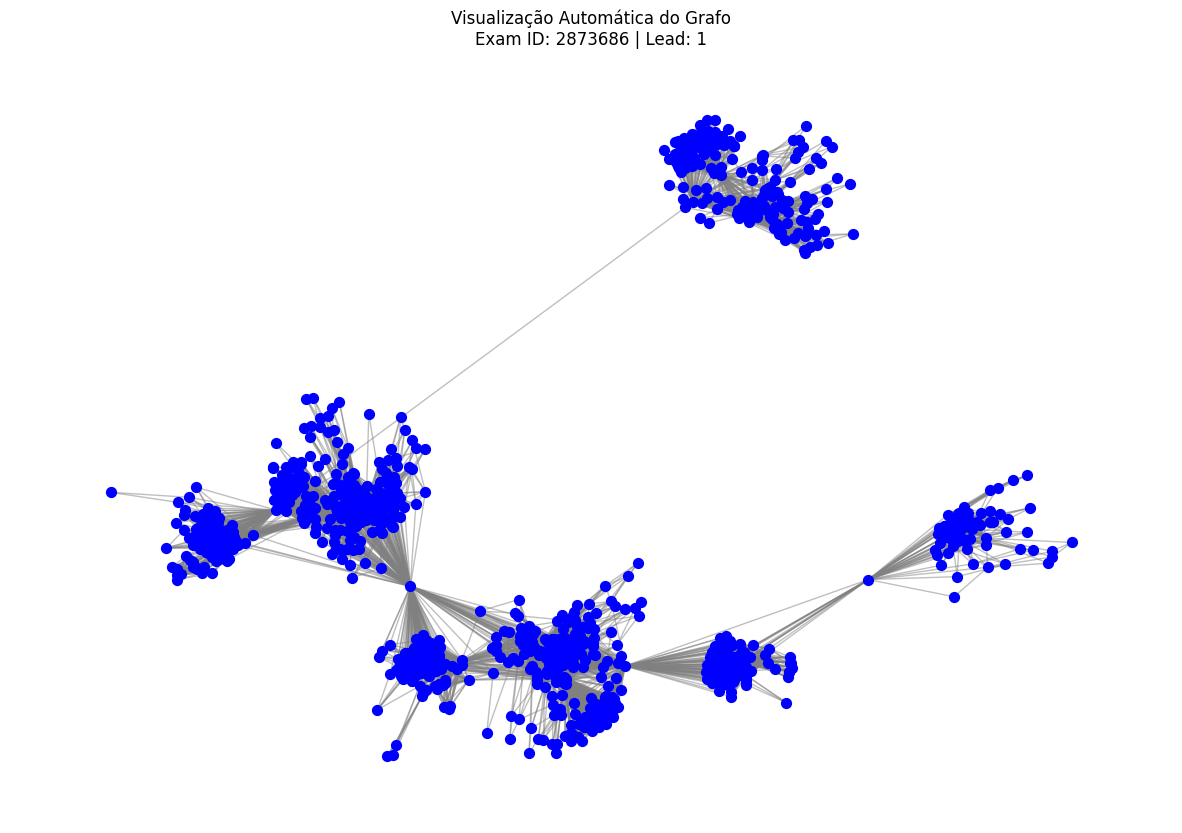

In [36]:
# visualizar_grafo.py
import torch
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def visualizar_grafo_com_matplotlib(pt_path, exam_id, lead_index):
    """
    Carrega o arquivo .pt contendo os grafos de ECG salvos pelo script salvar_grafos_ecg_pyg.py
    e visualiza o grafo de um ECG específico para um dado exam_id e lead, usando Matplotlib.
    Nesta visualização, os nós são posicionados de acordo com seu índice e o valor da amplitude (coluna 0).

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame.
        lead_index (int): Índice da lead a ser visualizada (0 a 11).
    """
    try:
        dados_salvos = torch.load(pt_path, weights_only = False)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado nos dados salvos.")
        return

    exam_dict = grafos_by_exam[exam_id]
    key_lead = f"lead_{lead_index}"
    if key_lead not in exam_dict:
        print(f"Lead {lead_index} não encontrada para o exame {exam_id}.")
        return

    # Aqui, cada grafo é um objeto Data do PyG
    graph_data = exam_dict[key_lead]
    edge_index = graph_data.edge_index  # tensor de shape [2, num_edges]
    node_features = graph_data.x        # tensor de shape [num_nodes, 3]

    # Extraia a amplitude (coluna 0) para definir a posição dos nós
    amplitude = node_features[:, 0].cpu().numpy()  # vetor de forma (num_nodes,)
    edges = edge_index.cpu().numpy()  # shape (2, num_edges)

    # Verifica a consistência: o número de nós esperado
    num_nodes = len(amplitude)
    if edges.size > 0:
        max_node = int(max(np.max(edges[0]), np.max(edges[1])))
        if max_node >= num_nodes:
            print("Atenção: O vetor de amplitude não cobre todos os nós do grafo.")
            num_nodes = max_node + 1

    # Cria o grafo usando NetworkX
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))
    print(f"Grafo do exam_id {exam_id} - lead {lead_index} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Define as posições dos nós: x = índice do nó, y = amplitude
    pos = {i: (i, amplitude[i]) for i in range(len(amplitude))}

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    plt.title(f"Visualização do Grafo de Visibilidade\nExam ID: {exam_id} | Lead: {lead_index}")
    plt.xlabel("Índice do Nó")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


def visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id, lead_index):
    """
    Carrega o arquivo .pt contendo os grafos de ECG salvos pelo script salvar_grafos_ecg_pyg.py
    e visualiza apenas o grafo de um ECG específico para um dado exam_id e lead, utilizando o layout automático do NetworkX.

    Args:
        pt_path (str): Caminho para o arquivo .pt contendo os grafos.
        exam_id (str/int): O ID do exame.
        lead_index (int): Índice da lead a ser visualizada (0 a 11).
    """
    try:
        dados_salvos = torch.load(pt_path, weights_only= False)
        grafos_by_exam = dados_salvos['grafos']
    except Exception as e:
        print(f"Erro ao carregar o arquivo .pt: {e}")
        return

    if exam_id not in grafos_by_exam:
        print(f"Exam ID '{exam_id}' não encontrado.")
        return

    exam_dict = grafos_by_exam[exam_id]
    key_lead = f"lead_{lead_index}"
    if key_lead not in exam_dict:
        print(f"Lead {lead_index} não encontrada para o exame {exam_id}.")
        return

    # Obter o objeto Data (grafo) e extrair as arestas
    graph_data = exam_dict[key_lead]
    edge_index = graph_data.edge_index  # tensor de shape [2, num_edges]
    edges = edge_index.cpu().numpy()

    # Cria o grafo com NetworkX apenas com as arestas
    G = nx.Graph()
    if edges.size > 0:
        G.add_edges_from(zip(edges[0], edges[1]))
    print(f"Grafo do exam_id {exam_id} - lead {lead_index} criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")

    # Layout automático (spring layout)
    pos = nx.spring_layout(G)

    # Plotagem
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='gray')
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    plt.title(f"Visualização Automática do Grafo\nExam ID: {exam_id} | Lead: {lead_index}")
    plt.axis("off")
    plt.show()


# Exemplo de uso:
if __name__ == "__main__":
    # Caminho para o arquivo .pt salvo pelo script salvar_grafos_ecg_pyg.py
    pt_path = "unlabel.pt"
    
    # Defina o exam_id e a lead que você deseja visualizar.
    # Certifique-se de que o exam_id exista no arquivo salvo.
    exam_id = 2873686  # ou outro ID existente nos seus dados
    lead_index = 1    # exemplo: visualize a lead 7
    
    # Visualiza o grafo com os nós posicionados de acordo com índice e amplitude
    visualizar_grafo_com_matplotlib(pt_path, exam_id, lead_index)
    
    # Visualiza apenas o grafo utilizando layout automático
    visualizar_apenas_grafo_com_matplotlib(pt_path, exam_id, lead_index)
